#Tags for Likes 
---
The aim of this project is to make a deep learning model that predicts if the number of likes are above or under the average based on hashtags. 



##Step 1: Exploring and Analyzing the dataset 

In [0]:
#Importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from collections import Counter
from datetime import datetime
import dateutil

import xgboost as xgb

from scipy import sparse
from IPython.display import Image

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

from keras.models import Sequential

from keras.layers import Dense, LSTM, Dropout, Activation, Dense, Input, CuDNNLSTM, Embedding, Dropout, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization

from keras.initializers import Constant

from sklearn.model_selection import train_test_split

In [0]:
#importing the dataset 
instagram_data = pd.read_csv('https://raw.githubusercontent.com/gvsi/instagram-like-predictor/master/dataset.csv')
#checking the features and content of the dataset 
instagram_data.head()

,numberPosts,website,urlProfile,username,numberFollowing,descriptionProfile,alias,numberFollowers,urlImgProfile,filename,date,urlImage,mentions,multipleImage,isVideo,localization,tags,numberLikes,url,description
0,988,www.sylviemeis.de,https://www.instagram.com/1misssmeis/,Sylvie Meis Official Account,233,TV Host Let's Dance for RTL Germany / SBS6 / P...,1misssmeis,720979,https://scontent.cdninstagram.com/t51.2885-19/...,18161288_472089323136061_5128727096486526976_n...,2017-04-29T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@fraukeludowig_official', '@rtl_exclusiv', '...",False,False,NaN,['#exclusivspezial'],10047,https://www.instagram.com/p/BTdS7XgBe4X/?taken...,With my lovely colleague @fraukeludowig_offici...
1,988,www.sylviemeis.de,https://www.instagram.com/1misssmeis/,Sylvie Meis Official Account,233,TV Host Let's Dance for RTL Germany / SBS6 / P...,1misssmeis,720979,https://scontent.cdninstagram.com/t51.2885-19/...,18161312_678529115665252_1780327406628765696_n...,2017-04-29T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@tine', '@rachelzoe', '@lecolook', '@letsdan...",False,False,NaN,"['#jumpsuit', '#glam', '#ootn']",16781,https://www.instagram.com/p/BTdRaquBZTD/?taken...,"My look last night, hosting Let's Dance! Style..."
2,988,www.sylviemeis.de,https://www.instagram.com/1misssmeis/,Sylvie Meis Official Account,233,TV Host Let's Dance for RTL Germany / SBS6 / P...,1misssmeis,720979,https://scontent.cdninstagram.com/t51.2885-19/...,18096206_126240614590026_6106733145975947264_n...,2017-04-27T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@letsdance', '@rtlde', '@rtlde', '@letsdance']",False,False,NaN,"['#rehearsalday', '#behindthescenes']",11227,https://www.instagram.com/p/BTZXesPhDsB/?taken...,Calm before the 'glam' storm! 💋💄💅🏻💆🏼💇🏼Tomorrow...
3,988,www.sylviemeis.de,https://www.instagram.com/1misssmeis/,Sylvie Meis Official Account,233,TV Host Let's Dance for RTL Germany / SBS6 / P...,1misssmeis,720979,https://scontent.cdninstagram.com/t51.2885-19/...,18094963_1399253156802062_6673302163394920448_...,2017-04-24T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@bydanienl', '@roland_mouret', '@casadeioffi...",False,False,NaN,"['#dress', '#shoes', '#glam']",21539,https://www.instagram.com/p/BTRS6IOhz6J/?taken...,🌼Today's look for QVC.. styled by @bydanienl #...
4,988,www.sylviemeis.de,https://www.instagram.com/1misssmeis/,Sylvie Meis Official Account,233,TV Host Let's Dance for RTL Germany / SBS6 / P...,1misssmeis,720979,https://scontent.cdninstagram.com/t51.2885-19/...,18011499_901505923322739_4323762320120479744_n...,2017-04-22T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@elisabettafranchi', '@serenagoldenbaum']",False,False,NaN,"['#weekend', '#yay', '#happyweekend', '#kiss']",21054,https://www.instagram.com/p/BTLTV46BKDF/?taken...,💋Happy Weekend Lovelies ❤ #weekend #yay #happy...


In [0]:
instagram_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16539 entries, 0 to 16538
Data columns (total 20 columns):
numberPosts           16539 non-null int64
website               14652 non-null object
urlProfile            16539 non-null object
username              16335 non-null object
numberFollowing       16539 non-null int64
descriptionProfile    16148 non-null object
alias                 16539 non-null object
numberFollowers       16539 non-null int64
urlImgProfile         16539 non-null object
filename              16539 non-null object
date                  16539 non-null object
urlImage              16539 non-null object
mentions              16539 non-null object
multipleImage         16539 non-null bool
isVideo               16539 non-null bool
localization          6887 non-null object
tags                  16539 non-null object
numberLikes           16539 non-null int64
url                   16539 non-null object
description           16319 non-null object
dtypes: bool(2), int

From this we see that the dataset consists of 20 columns and 16539 observations. 
It is clear from the head output and info output that it is a mixed dataset consisting of both numbers, text and images. 

Before exploring more we drop all missing values in the dataset: 

In [0]:
instagram_data.isnull()
instagram_data.dropna()

,numberPosts,website,urlProfile,username,numberFollowing,descriptionProfile,alias,numberFollowers,urlImgProfile,filename,date,urlImage,mentions,multipleImage,isVideo,localization,tags,numberLikes,url,description
26,938,www.youtube.com/watch?v=MXkqzeIlhSQ,https://www.instagram.com/3ala2o/,Alaa Ebrahim,466,Youtuber/Gamer/Vlogger/Business owner . Snapch...,3ala2o,792886,https://scontent.cdninstagram.com/t51.2885-19/...,17439338_1918954601674274_3041918009095487488_...,2017-03-28T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,[],False,False,"Amman, Jordan",[],12244,https://www.instagram.com/p/BSLemZvDnVI/?taken...,اسلم عليكم من الاردن 😋\nمن وين تتابعني؟ 😎
33,938,www.youtube.com/watch?v=MXkqzeIlhSQ,https://www.instagram.com/3ala2o/,Alaa Ebrahim,466,Youtuber/Gamer/Vlogger/Business owner . Snapch...,3ala2o,792886,https://scontent.cdninstagram.com/t51.2885-19/...,17076558_1364065980317268_6183115918109835264_...,2017-03-02T06:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,[],False,False,"Bologna, Italy",[],7002,https://www.instagram.com/p/BRJV_ItFLSi/?taken...,الحمدالله تم توثيقي اليوم في انستاقرام 😍 وحالي...
102,1830,basecolour.com,https://www.instagram.com/_hollyt/,BASE COLOUR | Holly Titheridge,844,Fashion & Lifestyle Photography ✉️ info@baseco...,_hollyt,137858,https://scontent.cdninstagram.com/t51.2885-19/...,18160700_150917122110600_3242401679403909120_n...,2017-04-30T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@shaun', '@gucci', '@camillaandmarc', '@coun...",False,False,Sydney Airport,[],2409,https://www.instagram.com/p/BThnFvIFRaW/?taken...,Jam packed next couple of days planned with @s...
103,1830,basecolour.com,https://www.instagram.com/_hollyt/,BASE COLOUR | Holly Titheridge,844,Fashion & Lifestyle Photography ✉️ info@baseco...,_hollyt,137858,https://scontent.cdninstagram.com/t51.2885-19/...,18160474_136661733542015_7830446260803862528_n...,2017-04-30T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@theoldclare', '@gucci', '@vogueaustralia', ...",False,False,The Old Clare Hotel,['#theoldclarehotel'],2883,https://www.instagram.com/p/BTgjOiolvlh/?taken...,"Touch down in Sydney, first stop Sunday night ..."
107,1830,basecolour.com,https://www.instagram.com/_hollyt/,BASE COLOUR | Holly Titheridge,844,Fashion & Lifestyle Photography ✉️ info@baseco...,_hollyt,137858,https://scontent.cdninstagram.com/t51.2885-19/...,17934550_1478580215546561_8361222017210384384_...,2017-04-28T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,['@visitmelbourne'],False,False,"Southbank, Victoria, Australia",[],1638,https://www.instagram.com/p/BTbSg51FW7j/?taken...,Friday night lights.. 🌟
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16497,973,youtu.be/57jckQFsAKU,https://www.instagram.com/zoepastelle/,Z o ë P a s t e l l e 🌸,974,"actress, fashion lover, creative mind, hungry ...",zoepastelle,127595,https://scontent.cdninstagram.com/t51.2885-19/...,18096199_1951208725161382_5769725178430881792_...,2017-04-26T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,[],False,False,Piraino,"['#adventure', '#travel', '#italy']",6656,https://www.instagram.com/p/BTV_46WhilI/?taken...,todays breaky situation 🍇☕️ off to next spot i...
16499,973,youtu.be/57jckQFsAKU,https://www.instagram.com/zoepastelle/,Z o ë P a s t e l l e 🌸,974,"actress, fashion lover, creative mind, hungry ...",zoepastelle,127595,https://scontent.cdninstagram.com/t51.2885-19/...,17818940_1402905413113712_4268329582412693504_...,2017-04-25T05:00:00.000Z,https://scontent.cdninstagram.com/t51.2885-15/...,"['@gucci', '@visilabch', '@gucci', '@ootdmagaz...",False,False,"Sicilia, Italy","['#wearesummer17', '#italy', '#ad']",5398,https://www.instagram.com/p/BTTiGn9Boxe/?taken...,woke up in beautiful sicily 💙 so happy with my...
16500,973,youtu.be/57jckQFsAKU,https://www.instagram.com/zoepastelle/,Z o ë P a s t e l l e 🌸,974,"actress, fashion lover, creative mind, h

In [0]:
#Checking the numerical values in the dataset
pd.options.display.float_format = '{:.2f}'.format
instagram_data.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,16539.00,16539.00,16539.00,16539.00
mean,2315.73,2590.56,997829.41,24414.26
std,2655.38,59090.66,1934400.77,64220.60
min,15.00,0.00,124965.00,0.00
25%,787.00,191.00,198039.00,3232.50
50%,1481.00,396.00,393843.00,7351.00
75%,2932.00,645.00,935310.00,18357.00
max,27671.00,1838511.00,22130730.00,1115123.00


The describe() gives an overview of the numerical features. 
From this we see that there is a big distribution between 75 % of the data and max for all the features. We also see that there is a big difference in the number of followers and following. 

We are now looking a bit deeper into the dataset - starting out by exploring the 'date' feature to see if there is a link between the time of the post and number of likes

In [0]:
#First we convert the dates to week days using pandas datetime function 
instagram_data['day_of_Week'] = pd.to_datetime(instagram_data['date']).dt.weekday_name.astype('category')
instagram_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16539 entries, 0 to 16538
Data columns (total 21 columns):
numberPosts           16539 non-null int64
website               14652 non-null object
urlProfile            16539 non-null object
username              16335 non-null object
numberFollowing       16539 non-null int64
descriptionProfile    16148 non-null object
alias                 16539 non-null object
numberFollowers       16539 non-null int64
urlImgProfile         16539 non-null object
filename              16539 non-null object
date                  16539 non-null object
urlImage              16539 non-null object
mentions              16539 non-null object
multipleImage         16539 non-null bool
isVideo               16539 non-null bool
localization          6887 non-null object
tags                  16539 non-null object
numberLikes           16539 non-null int64
url                   16539 non-null object
description           16319 non-null object
day_of_Week         

Then we check if there is a link between the day of the week and number of posts. 

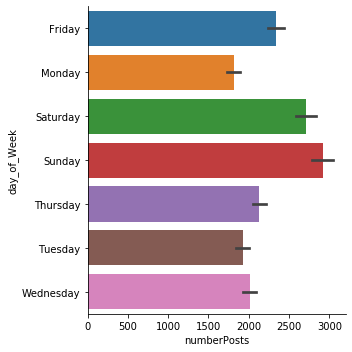

In [0]:
sns.catplot(x="numberPosts", y="day_of_Week", kind="bar", data=instagram_data);

The plot shows that most posts are posted in the weekends, while the days with the least posts are monday and tuesdays.

Next up, we look into the link between day of week and number of likes 

In [148]:
#We recode the numbers of likes to categorical to make it easier to spot a
# link, when plotting the categories as bars

#setting intervals set by the percentages set in the describe output so each 
#interval consists of 25 % of the samples
interval = (0, 3232, 7351, 18357, 1115123)
numberLikes_cat = ['0-3232', '3232-7351', '7351-18357', '18357-1115123']
instagram_data["numberLikes_cat"] = pd.cut(instagram_data.numberLikes, interval, labels=numberLikes_cat)

instagram_data.numberLikes_cat.value_counts(normalize=True)

3232-7351       0.31
7351-18357      0.30
0-3232          0.30
18357-1115123   0.10
Name: numberLikes_cat, dtype: float64

day_of_Week      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
numberLikes_cat                                                                
0-3232             0.14    0.11      0.15    0.20      0.15     0.12       0.13
3232-7351          0.14    0.10      0.15    0.19      0.15     0.13       0.14
7351-18357         0.15    0.12      0.15    0.18      0.14     0.13       0.14
18357-1115123      0.15    0.10      0.16    0.18      0.15     0.13       0.13


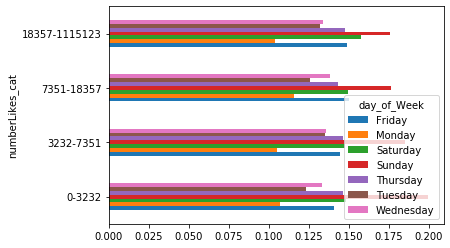

In [0]:
#Here we make an crosstab and plot of the link bewteen the number of likes and the day of the week 
day_likes = pd.crosstab(instagram_data.numberLikes_cat,instagram_data.day_of_Week, normalize='index')
print(day_likes)

figure = day_likes.plot(kind = 'barh')

From this we see posts posted on sundays gets the most likes followed up by saturdays. This makes sense considering that these also are the days with the most posts. 

Before creating, traning and testing any of our models, we want to explore the link between the numerical features. First plotting a pairplot of the features: number of followers, number of likes, number of following, number of posts and number of likes. 

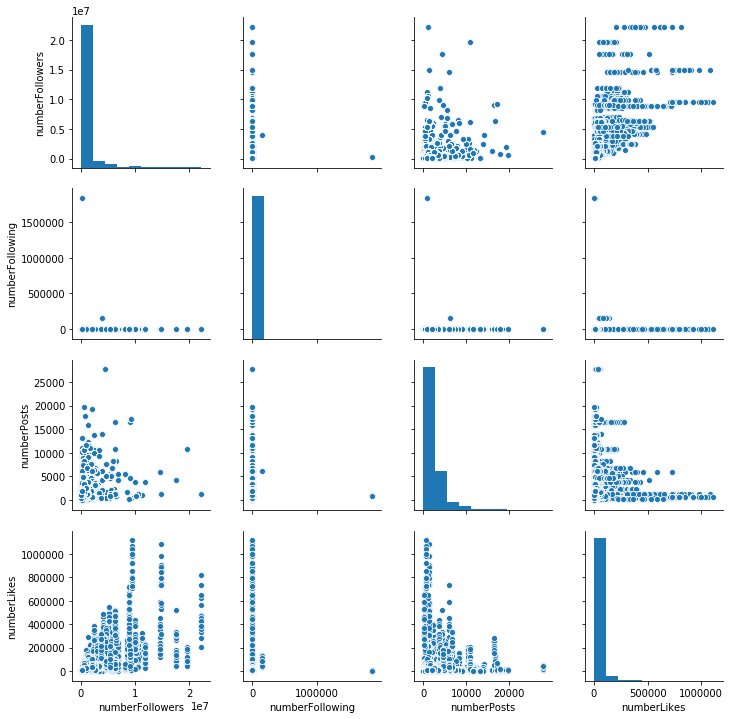

In [0]:
user=instagram_data[["numberFollowers", "numberFollowing", "numberPosts", 'numberLikes']]
sns.pairplot(user)

It is comon for most of the above plots that the samples are gathered in the right lower corner. This is also confirmed in the described output showing that there is a large distribution in the 25 % of the data with the highest values. Due to this we want to filter the features. By doing this we also reduce the number of outliers disturbing the result. This we do by setting a max for numerical features. 

In [0]:
#setting a new max for the numerical features: 
instagram_data = instagram_data[instagram_data.numberLikes <60000]
instagram_data = instagram_data[instagram_data.numberFollowers <1000000]
instagram_data = instagram_data[instagram_data.numberPosts <5000]
instagram_data = instagram_data[instagram_data.numberFollowing <1000]

In [0]:
pd.options.display.float_format = '{:.2f}'.format
instagram_data.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,10644.00,10644.00,10644.00,10644.00
mean,1561.75,381.03,353258.59,8316.72
std,1140.99,250.19,219680.95,8219.05
min,38.00,0.00,124965.00,0.00
25%,682.00,180.00,177856.00,2812.50
50%,1215.00,357.00,276353.00,5742.50
75%,2208.00,536.00,479108.00,10798.75
max,4983.00,999.00,990123.00,59470.00


As shown above, we now see a new distribution of the data. 
Now we want to plot the numerical features again to see if it gets easier to see the link bewteen the features

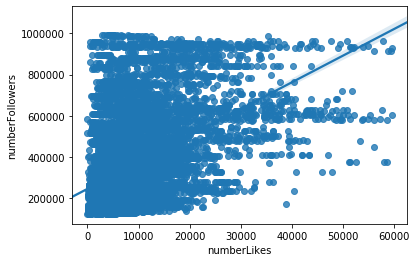

In [0]:
sns.regplot(x='numberLikes', y='numberFollowers', data=instagram_data)

From this scatterplot we see that just because you have more followers does not mean that you receive more likes, since posts with fewer followers receives approximately as many likes as the posts with more followers. 

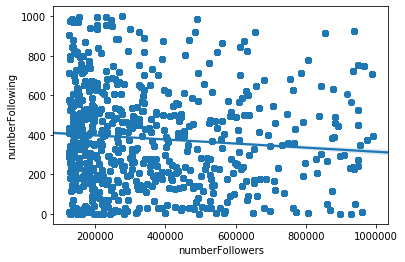

In [0]:
sns.regplot(x='numberFollowers', y='numberFollowing', data=instagram_data)

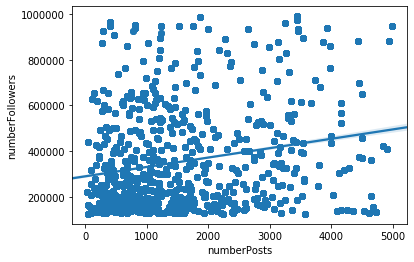

In [0]:
sns.regplot(x='numberPosts', y='numberFollowers', data=instagram_data)

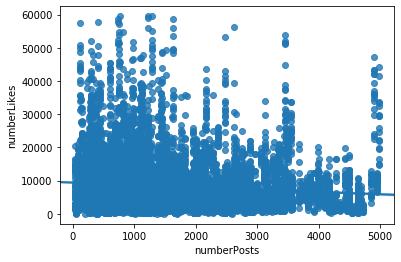

In [0]:
sns.regplot(x='numberPosts', y='numberLikes', data=instagram_data)

From the three above plots there is no direct link to see between the numerical features. 

Lastly before building our models we want to look at the 10 most common tags (just for fun) 

In [0]:
instagram_data['tags'].value_counts()[0:10]

[]                                                                                                                                                   4537
['#liketkit']                                                                                                                                          26
['#artofvisuals', '#aov', '#bevisuallyinspired']                                                                                                       17
['#vacationwolf']                                                                                                                                      17
['#alldaytravel']                                                                                                                                      17
['#SolelyNikes']                                                                                                                                       16
['#YourShotPhotographer']                                                   

Funnily enough we see that the most common tag is '[]' which means it has no tag. 

**Selecting features** 

Even though we did not directly see any links between the numerical features we are still interested in seeing if a basemodel can predict likes based on these features: 

*  Number of followers 
*  Number of posts 
*  Number of following 

## Step 2: Creating the Baseline Model 



We start building a XGBoost model as a base model. XGBoost is an advance implementation of Gradient Boosting, which can be used for classification problems to produce a prediction model. We have chosen the XGBoost because it is very effective, fast and works well out of the box. Its an esemble of weaker prediction models, like decisions trees, which makes it more efficient. The XGboost builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. 

**Step 2.1: Preprocessing for XGboost**

We start out by converting our y-variable, number of likes, to a dummy variable, making it possible to build a binary classification model. We split the samples in two set by the mean of the feature, making it possible to predict whether a post receives likes less or above the average. 

In [0]:
#Recoding Number of likes to categorical, setting the categories after the mean seen in the describe output and the new max value 
interval = (0, 8316.72, 75000)

#categorizing the categories
numberLikes_cat = ['less than mean', 'above mean']
instagram_data["numberLikes_cat"] = pd.cut(instagram_data.numberLikes, interval, labels=numberLikes_cat)

instagram_data.numberLikes_cat.value_counts(normalize=True)

less than mean   0.65
above mean       0.35
Name: numberLikes_cat, dtype: float64

The feature is now converted into two categories with a distribution of 65 and 35 %

We then convert the two categories to dummy variables, so it can fit in the XGBoost model

In [0]:
numberLikes_dummy = pd.get_dummies(instagram_data.numberLikes_cat)

#joining the dummy variables to the dataset
instagram_data = instagram_data.join(numberLikes_dummy)

In [0]:
#We can now set our x and y

features = ['numberPosts', 'numberFollowing', 'numberFollowers' ]

x = instagram_data.loc[:, features]

#We the the y to the dymmy variable 'above mean', meaning that this is what we want to predict. That means that the value 1, stand for true (above mean) and 0 for false (less than mean)
y = instagram_data.loc[:, 'above mean']

In [0]:
#then we normalize the data by scaling it: 

scaler = StandardScaler()

data_scaled = StandardScaler().fit_transform(x)

data_scaled.shape

(10644, 3)

In [0]:
#lastly before building the XGBoost model, we split the data into a training and a test set. Setting the size of the test set on 25 % 

x_train, x_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.25, random_state = 36)

step 2.2: building the XGBoost model: 

In [0]:
model = xgb.XGBClassifier()

scores = cross_val_score(model, x_train, y_train, cv = 5)
print(scores)

# Model training
model.fit(x_train, y_train)

predictions = model.predict(x_test)

# Model performance on the test-set
print(model.score(x_test, y_test))

[0.79524108 0.81465247 0.80400751 0.79336255 0.79498433]
0.8109733183013904


In this model the mean accuracy is about 81 %. To get a deeper look into the we look into the performance of the model

In [0]:
#Performance evaluation of XGBoost 
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1697
           1       0.79      0.65      0.71       964

    accuracy                           0.81      2661
   macro avg       0.80      0.78      0.79      2661
weighted avg       0.81      0.81      0.81      2661



In the performance evaluation we see that the model predicted 65 % of the likes above mean correct and 90 % of the likes less than mean correct.  

We visualize this performance in a confusion plot: 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4ceb755048>)

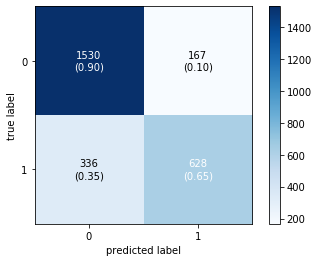

In [0]:
#confusion matrix of XGboost 
confmatrix = confusion_matrix(y_test,y_pred) 


plot_confusion_matrix(conf_mat=confmatrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True)

The confusion matrix visualizes the above perfomance evaluation. 
On the x axis we see what the model predicted. 1 means it predicted the result as above mean, and 0 means that the model predicted the result less the mean. On the y axis we see the real label, again 1 for the above mean, and 0 for less than mean. 

This means that in the box where 1 meets on the x and y axis, we see that it predicted the posts with likes above mean correct in 65 % of the times and where 0 meets on the two axis we see that the model predicted 90 % correct of the posts the likes less than mean - just like the performance evaluation showed. 

The two other areas shows the percentages where the model predicted wrong.

In conclusion it shows that the model is able to predict whether the number of likes is above or less than the mean (mostly in the cases where it is less) even though we did not see an direct link in the exploration of the variables. 
We are wondering if the tags attached to the posts has an influence on the likes. Therefore we now want to build a deep learning model, which can work with the tags to see if we the tags is a better prediction factor than the numeric or not. 

#Step 3: Building the Deep Learning model 

The deep learning model we want to build onto our base is LSTM. LSTM (Long Short-Term Memory) is a Recurrent Neural Network, where it learns from previous input what is the most important pieces of information and to select these. Explicitly, it ‘reads’ new input based on what it has learned from previous input. LSTM makes use of sequential data, wherefore it is ideal for types of text prediction, detection and generation, which is why we use it in this project.

**3.1. Preparing the data for our LSTM model**

To prepare the data, we use the tokenizer module from keras' library. The tokenizer module provides a lexical scanner for Python, where we turn the words into tokens and integers, making it possible for the model to read them. 

In [0]:
#we are using the tokenizer class to transform the texted tags to sequences 
vocabulary_size = 5000 #vocabulary_size indiciates the total of words 
tokenizer = Tokenizer(num_words = vocabulary_size)

#fitting the tokenizer model on the tags. 
tokenizer.fit_on_texts(instagram_data['tags'])

#Turning words into sequences 
sequences = tokenizer.texts_to_sequences(instagram_data['tags'])

#The tags are now split into integer-sequences, and we now pad these seqeunces 
#together at a maxlength at 120 elements
MAXLEN = 120
X = pad_sequences(sequences, maxlen=MAXLEN)

#again we set the y to the dummy variable 'above mean',
# meaning that the value 1 indivcates above mean, and 0 less than mean
y1 = instagram_data.loc[:, 'above mean']

In [0]:
#As a last step we create an index to add when splitting the data 
indices = range(len(X))

In [0]:
#Before building and training the network, we split the data to a train 
#and test dataset. 
#we add the indices here. This makes sure underrepresented categories are 
#weighed higher when training the network. 
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y1, indices,  test_size=0.2)

**3.2. Creating the model**

The first layer of the model is an embedding layer Embedding transforms the words (represented by integers) to meaningful vectors. Embedding vector length indicates the lenght of the vector each word/sequence is represented by. 

In [0]:
embedding_vecor_length = 300 

#Initializing the model as a sequential model 
model = Sequential() 

#Adding an input/embedding layer consisting of vocabulary size, 
#embedding vector length and input_length of the sequences at 120 
model.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=MAXLEN))
model.add(SpatialDropout1D(0.1))

#The next layer is the LSTM layer. Here 64 is indicated as the number of nodes
# in the hidden LSTM layer
model.add(LSTM(64)) 

#dropout helps prevent overfitting 
model.add(Dropout(0.2))

#Batch normalization normalizes the the data 
model.add(BatchNormalization())

#we use 'sigmoid' as activation function 
model.add(Dense(1, activation='sigmoid'))

Now that the model is build we can compile it

In [0]:
#we use 'binary crossentropy' as the loss because we are 
#working with a binary classification 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#The sumary shows the structure of the network as designed above 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 120, 300)          1500000   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 120, 300)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,593,761
Trainable params: 1,593,633
Non-trainable params: 128
_________________________________________

**3.3 Training the model** 

We can now train our model with the data. We set the batch size to 240 and epochs to 3, meaning that the training data is split in batches consisting of 240 observations each, and that the learning algorithm goes through all of these batches 3 times. Validation split indicates how much of the training data to be used asvalidation data. 

In [0]:
model.fit(X_train, y_train, epochs=3, batch_size=240, validation_split=0.1)

Train on 7663 samples, validate on 852 samples
Epoch 1/3
7663/7663 [==============================] - 14s 2ms/step - loss: 0.6474 - acc: 0.5966 - val_loss: 0.5501 - val_acc: 0.7077
Epoch 2/3
7663/7663 [==============================] - 8s 1ms/step - loss: 0.4993 - acc: 0.7175 - val_loss: 0.5439 - val_acc: 0.7113
Epoch 3/3
7663/7663 [==============================] - 8s 1ms/step - loss: 0.4467 - acc: 0.7407 - val_loss: 0.5818 - val_acc: 0.7101


For the epochs we get an accuracy on respectively 62,5 %, 72 % and 70 % 

#4: Predicting on the model 

Now the model have been trained with the data and we can now elaborate how well it predicts.

In [0]:
#First we indicate how many tags we want a prediction of
start = 0
end = 50

In [0]:
# Then we use the test data to predict 
y_pred = model.predict(X_test[start:end])

y_pred = np.where(y_pred > 0.5, True, False)
y_pred = [list(x) for x in y_pred]

# We then define the real label which makes it possible to compare the 
#predicted tweets with the real.
real_label = instagram_data['above mean'][index_test[start:end]]

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


We can now show the predicted labels and the real labels, making it easy to compare these

In [0]:
pd.DataFrame({'prediction':y_pred, 'real': real_label})

,prediction,real
5019,[True],0.00
3758,[False],nan
9037,[False],0.00
3468,[False],0.00
722,[False],0.00
3787,[False],1.00
604,[False],1.00
627,[False],nan
1566,[True],1.00
3613,[True],nan


Lastly we run the final evaluation of the model

In [0]:
results = model.evaluate(X_test, y_test)
print("The Loss and Accuracy:", results)

2129/2129 [==============================] - 6s 3ms/step
The Loss and Accuracy: [0.5936839776511705, 0.7050258338927327]


Everytime we run the model we get a final accuracy between 68 and 74 %

#5: Conclusion

In the end we have built a model which can predict whether an Instagram post will get above or under the average mean of likes (8316), depending on hashtags used. We saw that our baseline model had an accuracy of 83%, where our deep learning model had a lower accuracy of about 70 %. This is due to the baseline model only worked on numerical values and the deep learning model used a more complex data such as text. However, we still consider the deep learning model to be relatively valid enough within this context, since we see that the tags have influence on the likes.

We noticed that the LSTM model have a relatively high accuracy compared to the table showing the predictions, where the predicitons does not look particulary good. These might have something to do with the NaN still being in the data, showed in table with predictions, even though we dropped all missing values doing the preprocessing of the data. These NaNs might have an influence on the result and cause sources of error in the result. 

We also see that the model predicts False very often. This could indicate, that it is the 'False' results that is predicted right. This was also the pattern we saw in the XGBoost model and might be due to the distibution of the samples in the categories. As shown when recoding number of likes to categories 65 % of the observations is placed in the categori 'less than mean' while only 35 % of the observations is placed in the categori 'above mean'. 

At last there is definitely room for improvement on this model. For a more realistic and accurate prediction it would be necessary to take images and time of posting into account as well. For the image analysis we suggest adding a CNN model layer (e.g. ResNet or VGG16), since it is great for these types of issues. Additionally, it would be necessary to collect more data as well to improve accuracy and the validity of the model. 
